In [65]:
import copy

from alns import ALNS
from alns.select import RouletteWheel
from alns.stop import MaxRuntime
from alns.accept import HillClimbing

import numpy as np
from functions.part1 import part1
from classes.deliveryrouting import DeliveryRouting

In [66]:
instance_dir = "data/0o50t75s1p100"
dr = DeliveryRouting(instance_dir)
dr.driver_code()

In [96]:
def random_destroy(State : DeliveryRouting, rnd_state : np.random.seed = np.random.seed(42)):
    destroyed = copy.deepcopy(State)
    destroyed.current_solution = copy.deepcopy(destroyed.final_result)

    order_destroyed = np.random.choice(destroyed.orders)
    destroyed.unassigned = order_destroyed

    for time, routes in destroyed.final_result.items():
        for route in routes:
            for bundle in route:
                if order_destroyed in bundle.bundle:
                    bundle.bundle.remove(order_destroyed)
    return destroyed

In [100]:
def greedy_assign(State: DeliveryRouting, rnd_state : np.random.seed = np.random.seed(42)):
    repaired = copy.deepcopy(State)
    destroyed_order = repaired.unassigned

    min_time = 1e9
    done = False
    for time, routes in repaired.final_result.items():
        for route in routes:
            for bundle in route:
                if destroyed_order.ready_time >= time:
                    for i in range(len(bundle.bundle)):
                        temp_bundle = copy.deepcopy(bundle)
                        temp_bundle.bundle.insert(i, destroyed_order)
                        if temp_bundle.get_route_cost(repaired.meters_per_minute, repaired.locations) < min_time:
                            min_time = temp_bundle.get_route_cost(repaired.meters_per_minute, repaired.locations)
                            best_route = bundle
                            done = True
                            index = i

    if done:
        best_route.bundle.insert(index, destroyed_order)
        return repaired
    else:
        repaired.final_result = repaired.current_solution
        return repaired

In [101]:
import numpy.random as rnd

alns = ALNS(rnd.RandomState(42))
alns.add_destroy_operator(random_destroy)
alns.add_repair_operator(greedy_assign)

In [107]:
init = dr
select = RouletteWheel([8, 4, 2, 1], 0.8, 1, 1)
accept = HillClimbing()
stop = MaxRuntime(240)

result = alns.iterate(init, select, accept, stop)

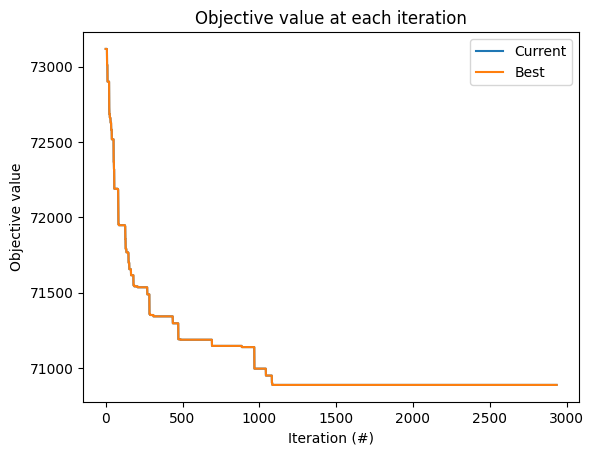

In [108]:
result.plot_objectives()

In [118]:
best_result = result.best_state